# DSC450 Project 3 - Updated Cleaned Version (8.3.25)


---

# DSC450-T301 - Project 3: Project Draft Group Assignment (Milestone 1)

---

**Professor**: Fadi Alsaleem<br>
**@Copyright**: BELLEVUE.edu<br>
**OS**: Windows 11 x64<br>
**Processor**: i9-13900<br>
**GPU**: NVIDIA GeForce RTX 5080<br>
**IDE**: VS Code<br>
**Interpreter**: Python 3.13<br>
**Libraries Managed by**: Miniforge3<br><br>

---

**Team Roles**:<br>
1. **Data Wrangler**: Tyler Heflin<br>
**Responsibilities**:
- Data acquisition
- Cleaning
- Transformation
- Quality Assessment
2. **Data Scientist**: Andres Melendez<br>
**Responsibilities**:
- Data exploration
- Model Development
- Analysis
- Recommendations
3. **Data Visualizer**: Carlos Escamilla<br>
**Responsibilities**:
- Create visualizations
4. **Data Presenter**: Delilah Slabaugh<br>
**Responsibilities**:
- Presentation Design
- Storytelling

---

**Version**:
- 1.0.0 - 2025.07.21 Week8 - Milestone 1: Proposal and Data Selection Group Assignment
- 1.0.1 - 2025.07.28 Week9 - Milestone 2: Project Draft Group Assignment
- 1.0.1 - 2025.08.04 Week10 - Milestone 3: Presentation and Team Evaluation

**Resources**:
- [Hospital Readmission Prediction Dataset (Synthetic Dataset)](https://www.kaggle.com/datasets/siddharth0935/hospital-readmission-predictionsynthetic-dataset)

---
# DATA WRANGLER
---
**Author**:<br>
Tyler Heflin

### Load the Dataset
---

To begin, the CSV file is loaded into a pandas DataFrame and a preview of the structure is returned. This step initializes the project and checks the shape to understand what exists before transformations occur. Checking expectations against what exists is integral to the success of the project.

In [1]:
import pandas as pd

# Load the dataset
df = pd.read_csv("hospital_readmissions_30k.csv")

# Display shape and preview
print(df.shape)
df.head()

(30000, 12)


,patient_id,age,gender,blood_pressure,cholesterol,bmi,diabetes,hypertension,medication_count,length_of_stay,discharge_destination,readmitted_30_days
0,1,74,Other,130/72,240,31.5,Yes,No,5,1,Nursing_Facility,Yes
1,2,46,Female,120/92,292,36.3,No,No,4,3,Nursing_Facility,No
2,3,89,Other,135/78,153,30.3,No,Yes,1,1,Home,No
3,4,84,Female,123/80,153,31.5,No,Yes,3,10,Home,No
4,5,32,Other,135/84,205,18.4,No,Yes,6,4,Nursing_Facility,No


---
### Check Missing Values and Data Types
---

Next, missing values and data types for each column are identified. Preprocessing steps are highly dependent on whether features are categorical, numeric, or improperly formatted. This also assists with knowing wihich features need imputation, conversion, or cleanup.

In [2]:
# Check for nulls
print(df.isnull().sum())

# Check data types
print(df.dtypes)

patient_id               0
age                      0
gender                   0
blood_pressure           0
cholesterol              0
bmi                      0
diabetes                 0
hypertension             0
medication_count         0
length_of_stay           0
discharge_destination    0
readmitted_30_days       0
dtype: int64
patient_id                 int64
age                        int64
gender                    object
blood_pressure            object
cholesterol                int64
bmi                      float64
diabetes                  object
hypertension              object
medication_count           int64
length_of_stay             int64
discharge_destination     object
readmitted_30_days        object
dtype: object


---
### Split column for Blood Pressure
---

Here, the systolic and diastolic values are parse from a string column into numeric features. Vital sign components are both not usable in raw string format and also have predictive power individually. Having these in a numeric format can harness these features for statistical modeling or imputation.

In [3]:
# Split into systolic and diastolic
df[['systolic_bp', 'diastolic_bp']] = df['blood_pressure'].str.split('/', expand=True)
df['systolic_bp'] = pd.to_numeric(df['systolic_bp'], errors='coerce')
df['diastolic_bp'] = pd.to_numeric(df['diastolic_bp'], errors='coerce')

# Drop original
df.drop(columns='blood_pressure', inplace=True)
print(df.head())

   patient_id  age  gender  cholesterol   bmi diabetes hypertension  \
0           1   74   Other          240  31.5      Yes           No   
1           2   46  Female          292  36.3       No           No   
2           3   89   Other          153  30.3       No          Yes   
3           4   84  Female          153  31.5       No          Yes   
4           5   32   Other          205  18.4       No          Yes   

   medication_count  length_of_stay discharge_destination readmitted_30_days  \
0                 5               1      Nursing_Facility                Yes   
1                 4               3      Nursing_Facility                 No   
2                 1               1                  Home                 No   
3                 3              10                  Home                 No   
4                 6               4      Nursing_Facility                 No   

   systolic_bp  diastolic_bp  
0          130            72  
1          120            92  

---
### Convert Categorical Variables to Category Type
---

In this step, relevant columns are converted to categorical data types for efficiency and clarity. This saves memory and enables faster, more accurate, encoding later. To that end, this will facilitate encoding and meaningful descriptive statistics in later steps.

In [4]:
# Convert to categorical type
categorical_cols = ['gender', 'diabetes', 'hypertension', 'discharge_destination', 'readmitted_30_days']
for col in categorical_cols:
    df[col] = df[col].astype('category')

---
### Encode the Target Variable
---

Next, the column that is the target variable ('readmitted_30_days') is converted from "Yes/No" to 1/0. Most ML models require a numeric target variable and binary classification benefits from this convention. Having clean targets ensures valid model training and ROC/AUC evaluation.

In [5]:
# Convert target to binary
df['readmitted_30_days'] = df['readmitted_30_days'].map({'Yes': 1, 'No': 0})

---
### Feature Engineering - BMI
---

For this step, the 'bmi' column is transformed into clinically interpretable categories. This aids in encoding and model explainability by aligning with CDC guidelines for BMI ranges.

In [6]:
# Create BMI categories
def bmi_category(bmi):
    if bmi < 18.5:
        return 'Underweight'
    elif bmi < 25:
        return 'Normal'
    elif bmi < 30:
        return 'Overweight'
    else:
        return 'Obese'
    
df['bmi_category'] = df['bmi'].apply(bmi_category).astype('category')

---
### Data Quality Assessment
---

Here, a high-level summary is provided and visually inspected for potential outliers and data quality issues. Outliers for features like 'length_of_stay' and 'bmi' can skew model performance, so a decision must be made to either clip or transform the skewed data.

          patient_id           age gender   cholesterol           bmi  \
count   30000.000000  30000.000000  30000  30000.000000  30000.000000   
unique           NaN           NaN      3           NaN           NaN   
top              NaN           NaN   Male           NaN           NaN   
freq             NaN           NaN  10097           NaN           NaN   
mean    15000.500000     53.884233    NaN    225.260400     28.946263   
std      8660.398374     21.056485    NaN     43.585671      6.348204   
min         1.000000     18.000000    NaN    150.000000     18.000000   
25%      7500.750000     36.000000    NaN    188.000000     23.400000   
50%     15000.500000     54.000000    NaN    225.000000     28.900000   
75%     22500.250000     72.000000    NaN    263.000000     34.500000   
max     30000.000000     90.000000    NaN    300.000000     40.000000   

       diabetes hypertension  medication_count  length_of_stay  \
count     30000        30000      30000.000000    30000.0

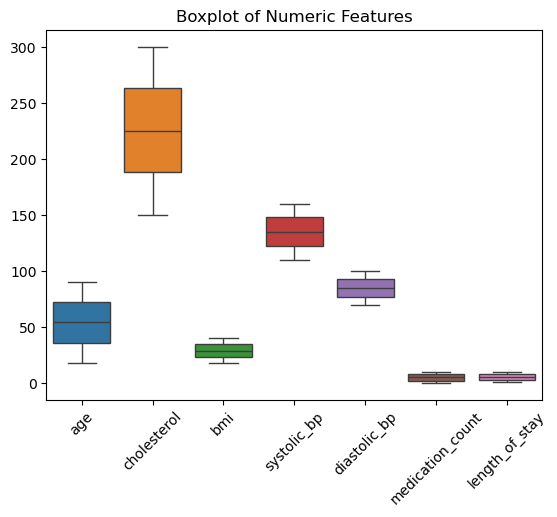

In [7]:
# Descriptive stats
print(df.describe(include='all'))

# Boxplots for outlier detection
import matplotlib.pyplot as plt
import seaborn as sns

numeric_cols = ['age', 'cholesterol', 'bmi', 'systolic_bp', 'diastolic_bp', 'medication_count', 'length_of_stay']
sns.boxplot(data=df[numeric_cols])
plt.title("Boxplot of Numeric Features")
plt.xticks(rotation=45)
plt.show()

---
### Impute Missing Values
---

In this step, any missing data is handled using statistical imputation. Median and mode are robust against outliers and preserve distribution.

In [8]:
import warnings
warnings.filterwarnings('ignore')

# Fill missing numeric values with median
df['age'].fillna(df['age'].median(), inplace=True)
df['cholesterol'].fillna(df['cholesterol'].median(), inplace=True)
df['bmi'].fillna(df['bmi'].median(), inplace=True)
df['systolic_bp'].fillna(df['systolic_bp'].median(), inplace=True)
df['diastolic_bp'].fillna(df['diastolic_bp'].median(), inplace=True)
df['medication_count'].fillna(df['medication_count'].median(), inplace=True)
df['length_of_stay'].fillna(df['length_of_stay'].median(), inplace=True)

# Fill missing categorical with mode
for col in categorical_cols:
    if df[col].isnull().any():
        df[col].fillna(df[col].mode()[0], inplace=True)

---
### Encode Categorical Features for Modeling
---

Next, multi-class categorical variables are converted into numeric indicators. ML algorithms such as Random Forest and XGBoost require numeric input. Future steps are dependent on feeding encoded data into the modeling pipeline.

In [9]:
# One-hot encode nomial variables
df = pd.get_dummies(df, columns=['gender', 'discharge_destination', 'bmi_category'], drop_first=True)

---
### Final Checks and Correlation Heatmap
---

Here, final checks are performed to verify cleanliness and visualize linear correlations. This provides identification for redundant variables and early signals about strong predictors. The correlations may further aid in informing feature selection or SHAP interpretability.

Duplicate rows: 0
Remaining nulls:
 patient_id                                0
age                                       0
cholesterol                               0
bmi                                       0
diabetes                                  0
hypertension                              0
medication_count                          0
length_of_stay                            0
readmitted_30_days                        0
systolic_bp                               0
diastolic_bp                              0
gender_Male                               0
gender_Other                              0
discharge_destination_Nursing_Facility    0
discharge_destination_Rehab               0
bmi_category_Obese                        0
bmi_category_Overweight                   0
bmi_category_Underweight                  0
dtype: int64


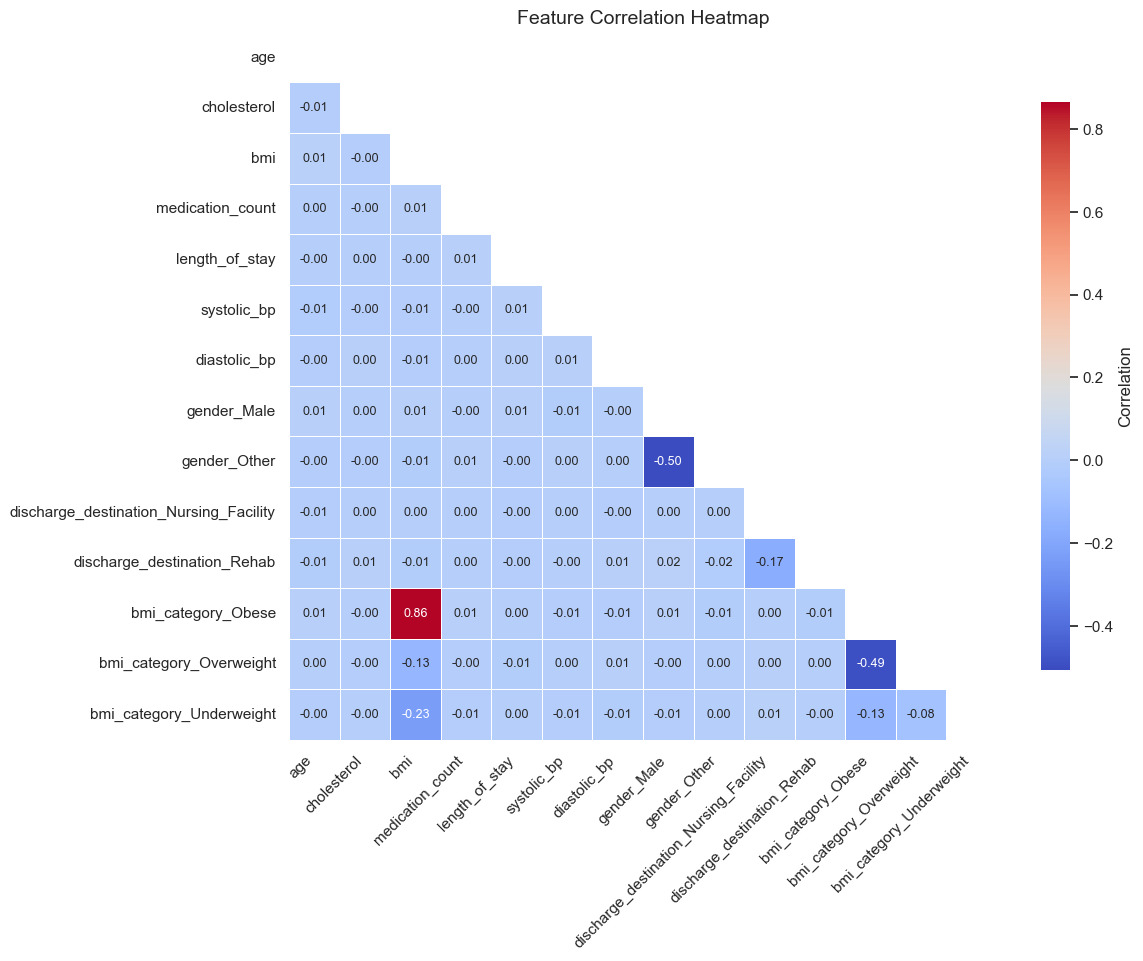

In [10]:
import numpy as np

# Check for dups
print("Duplicate rows:", df.duplicated().sum())

# Check for nulls
print("Remaining nulls:\n", df.isnull().sum())

# Correlation matrix
plt.figure(figsize=(12, 10))
sns.set(style="white")

corr = df.drop(columns=['patient_id']).corr(numeric_only=True)
mask = np.triu(np.ones_like(corr, dtype=bool))

sns.heatmap(
    corr,
    mask=mask, 
    annot=True,
    fmt=".2f",
    cmap='coolwarm',
    square=True,
    linewidth=0.5,
    cbar_kws={"shrink": 0.75, "label": "Correlation"},
    annot_kws={"size": 9}
)

plt.title("Feature Correlation Heatmap", fontsize=14)
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

---
### Save the Dataset
---

In [11]:
df.to_csv("hos_readm_cleaned.csv", index=False)
print("Cleaned dataset saved as 'hos_radm_cleaned.csv'.")

Cleaned dataset saved as 'hos_radm_cleaned.csv'.


### KEY INSIGHTS AND RECOMMENDATIONS
---
- Key findings summary
- Recommendations for the Data Visualizer team member

#### **Key Findings Summary**
---

1. All features are clean, encoded, and usable for classification models.
2. Categorical inputs were preserved where clinically useful (i.e., BMI, discharge).
3. The target variable is formatted for binary classification.
4. Blood pressure was split for more granular insights.
5. Data quality was assessed through visual and statistical checks.

#### **Recommendations for Data Scientist**
---

1. Train baseline models (i.e., logistic regression, Random Forest, XGBoost).
2. Use SHAP for global and local model explainability.
3. Tune hyperparameters with cross-validation.
4. Create a clinician-facing dashboard (i.e., Streamlit + SHAP visualizations).
5. Document model assumptions, limitations, and future validation plans.


---
# DATA SCIENTIST
---
**Description**:<br>


**Data Scientists**:<br>
Andres Melendez

### Load Dataset
---

In [12]:
df = pd.read_csv("hos_readm_cleaned.csv")

print(df.head())

# Convert Yes/No columns directly to boolean for training
cols_to_map = ['diabetes', 'hypertension']

for col in cols_to_map:
    df[col] = df[col].map({'Yes': True, 'No': False})

print(df.dtypes)
print(df.head())

   patient_id  age  cholesterol   bmi diabetes hypertension  medication_count  \
0           1   74          240  31.5      Yes           No                 5   
1           2   46          292  36.3       No           No                 4   
2           3   89          153  30.3       No          Yes                 1   
3           4   84          153  31.5       No          Yes                 3   
4           5   32          205  18.4       No          Yes                 6   

   length_of_stay  readmitted_30_days  systolic_bp  diastolic_bp  gender_Male  \
0               1                   1          130            72        False   
1               3                   0          120            92        False   
2               1                   0          135            78        False   
3              10                   0          123            80        False   
4               4                   0          135            84        False   

   gender_Other  discharge

---
### Train/Test Split
---

In [13]:
from sklearn.model_selection import train_test_split

# Drop non-informative columns
X = df.drop(['readmitted_30_days', 'patient_id'], axis=1, errors='ignore')
y = df['readmitted_30_days']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

print(f"Training samples: {X_train.shape[0]}, Testing samples: {X_test.shape[0]}")

Training samples: 24000, Testing samples: 6000


In [14]:
print(X_train.dtypes)
print(X_train.head())

age                                         int64
cholesterol                                 int64
bmi                                       float64
diabetes                                     bool
hypertension                                 bool
medication_count                            int64
length_of_stay                              int64
systolic_bp                                 int64
diastolic_bp                                int64
gender_Male                                  bool
gender_Other                                 bool
discharge_destination_Nursing_Facility       bool
discharge_destination_Rehab                  bool
bmi_category_Obese                           bool
bmi_category_Overweight                      bool
bmi_category_Underweight                     bool
dtype: object
       age  cholesterol   bmi  diabetes  hypertension  medication_count  \
7445    24          270  23.5      True          True                 1   
28092   21          246  20.4     Fa

---
### RF + XGBoost Model Training
---

In [15]:
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

# Random Forest pipeline
rf_pipeline = Pipeline([
    ('model', RandomForestClassifier(random_state=42))
])

# XGBoost pipeline
xgb_pipeline = Pipeline([
    ('model', XGBClassifier(
        random_state=42,
        scale_pos_weight=(y_train.value_counts()[0]/y_train.value_counts()[1])
    ))
])

---
### Hyperparameter Tuning (CV)
---

### Random Forest

In [16]:
from sklearn.model_selection import GridSearchCV

rf_params = {
    'model__n_estimators': [100, 200, 300],
    'model__max_depth': [None, 5, 10],
    'model__min_samples_split': [2, 5]
}

rf_grid = GridSearchCV(rf_pipeline, rf_params, scoring='roc_auc', cv=5, n_jobs=-1)
rf_grid.fit(X_train, y_train)

print("Best RF params:", rf_grid.best_params_)
print("Best RF CV ROC-AUC", rf_grid.best_score_)

Best RF params: {'model__max_depth': 5, 'model__min_samples_split': 5, 'model__n_estimators': 200}
Best RF CV ROC-AUC 0.578804215135505


### XGBoost

In [17]:
xgb_params = {
    'model__n_estimators': [200, 300],
    'model__max_depth': [3, 5, 7],
    'model__learning_rate': [0.05, 0.1],
    'model__subsample': [0.8, 1.0],
    'model__colsample_bytree': [0.8, 1.0]
}

xgb_grid = GridSearchCV(xgb_pipeline, xgb_params, scoring='roc_auc', cv=5, n_jobs=-1)
xgb_grid.fit(X_train, y_train)

print("Best XGB params:", xgb_grid.best_params_)
print("Best XGB CV ROC-AUC", xgb_grid.best_score_)

Best XGB params: {'model__colsample_bytree': 1.0, 'model__learning_rate': 0.05, 'model__max_depth': 3, 'model__n_estimators': 200, 'model__subsample': 0.8}
Best XGB CV ROC-AUC 0.5714623346485552


---
### Model Evaluation and Comparison
---

=== Random Forest ===
              precision    recall  f1-score   support

           0       0.88      1.00      0.93      5265
           1       0.00      0.00      0.00       735

    accuracy                           0.88      6000
   macro avg       0.44      0.50      0.47      6000
weighted avg       0.77      0.88      0.82      6000

ROC-AUC: 0.5680655852084424
=== XGBoost ===
              precision    recall  f1-score   support

           0       0.89      0.74      0.81      5265
           1       0.17      0.38      0.23       735

    accuracy                           0.70      6000
   macro avg       0.53      0.56      0.52      6000
weighted avg       0.81      0.70      0.74      6000

ROC-AUC: 0.562461254207286


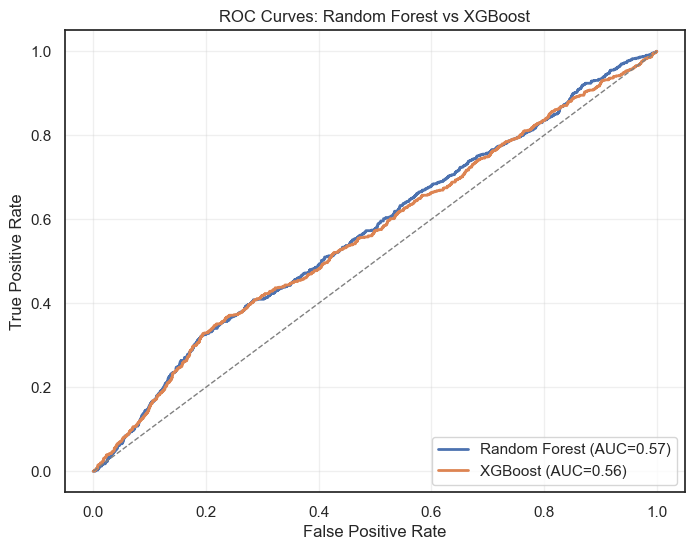

In [18]:
from sklearn.metrics import classification_report, roc_auc_score, roc_curve
import matplotlib.pyplot as plt

# Extract tuned models
rf_best = rf_grid.best_estimator_
xgb_best = xgb_grid.best_estimator_

# Predictions and probs
rf_preds = rf_best.predict(X_test)
rf_probs = rf_best.predict_proba(X_test)[:,1]

xgb_preds = xgb_best.predict(X_test)
xgb_probs = xgb_best.predict_proba(X_test)[:,1]

# Eval reports
print("=== Random Forest ===")
print(classification_report(y_test, rf_preds))
print("ROC-AUC:", roc_auc_score(y_test, rf_probs))

print("=== XGBoost ===")
print(classification_report(y_test, xgb_preds))
print("ROC-AUC:", roc_auc_score(y_test, xgb_probs))

# Visualizations
rf_fpr, rf_tpr, _ = roc_curve(y_test, rf_probs)
xgb_fpr, xgb_tpr, _ = roc_curve(y_test, xgb_probs)

plt.figure(figsize=(8,6))
plt.plot(rf_fpr, rf_tpr, label=f"Random Forest (AUC={roc_auc_score(y_test, rf_probs):.2f})", lw=2)
plt.plot(xgb_fpr, xgb_tpr, label=f"XGBoost (AUC={roc_auc_score(y_test, xgb_probs):.2f})", lw=2)

# Reference line
plt.plot([0,1], [0,1], linestyle='--', color='gray', lw=1)

# Plot format
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curves: Random Forest vs XGBoost")
plt.legend(loc="lower right")
plt.grid(alpha=0.3)
plt.show()

---
### Feature Importance Comparison
---

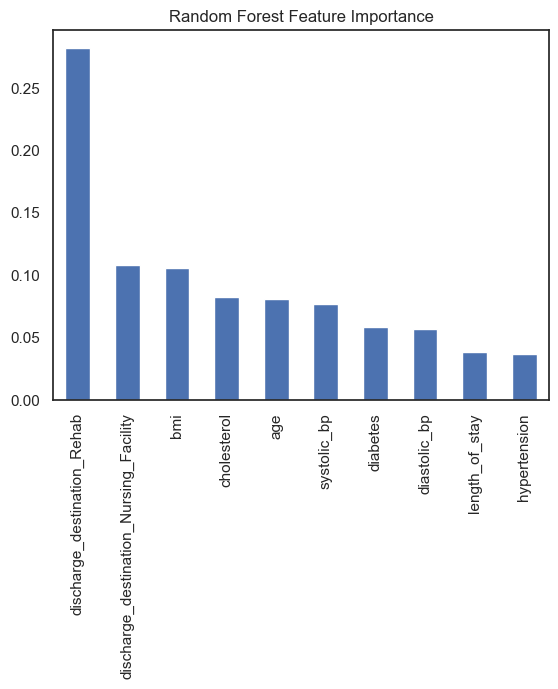

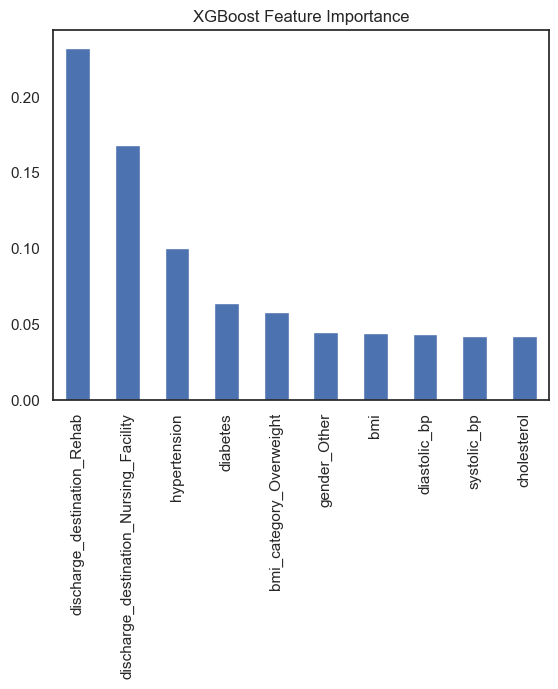

In [19]:
import pandas as pd
import matplotlib.pyplot as plt

# RF
rf_importances = pd.Series(rf_best.named_steps['model'].feature_importances_, index=X.columns)
rf_importances.sort_values(ascending=False).head(10).plot(kind='bar', title="Random Forest Feature Importance")
plt.show()

# XGB
xgb_importances = pd.Series(xgb_best.named_steps['model'].feature_importances_, index=X.columns)
xgb_importances.sort_values(ascending=False).head(10).plot(kind='bar', title="XGBoost Feature Importance")
plt.show()

### KEY INSIGHTS AND RECOMMENDATIONS
---
- Key findings summary
- Recommendations for future iterations of this project
- Recommendations for the Data Visualizer team member

#### Key Findings Summary
- The dataset was highly imbalanced, with significantly more patients not readmitted within 30 days.
- Both models—Random Forest and XGBoost—had low ROC-AUC scores (0.57 and 0.56 respectively), indicating poor ability to discriminate between readmitted and non-readmitted patients.
- **Random Forest** had high overall accuracy (88%) but failed to correctly classify most positive cases (Recall = 0.00).
- **XGBoost** performed slightly better in identifying readmitted patients (Recall = 0.38) but at the cost of reduced overall accuracy.
- Feature importance analyses identified **discharge destination (Rehab, Nursing Facility)** as the most influential variable in predicting readmission, followed by BMI, age, and presence of chronic conditions.

---


#### **Recommendations for Future Project Iterations**
- **Address Class Imbalance**: Apply techniques like SMOTE, ADASYN, or class weighting to better handle the imbalance in the target variable.
- **Feature Enrichment**: Include additional variables such as past hospitalizations, follow-up care, medication compliance, and severity of illness.
- **Model Exploration**: Test other algorithms such as Logistic Regression, Gradient Boosting, or even neural networks, paired with robust hyperparameter tuning.
- **Performance Evaluation**: Move beyond accuracy and include metrics like F1-score, recall, and precision, especially for the minority class.
- **Fairness Assessment**: Analyze subgroup performance to ensure the model is not biased by gender, age, or discharge destination.

---


#### **Recommendations for Data Visualizer**
---

---
# Data Visualizer
---
**Data Visualizer**:<br>
Carlos Escamilla

In [20]:
import pandas as pd

# load the clean dataset
dfDV = pd.read_csv("hos_readm_cleaned.csv")
dfDV

,patient_id,age,cholesterol,bmi,diabetes,hypertension,medication_count,length_of_stay,readmitted_30_days,systolic_bp,diastolic_bp,gender_Male,gender_Other,discharge_destination_Nursing_Facility,discharge_destination_Rehab,bmi_category_Obese,bmi_category_Overweight,bmi_category_Underweight
0,1,74,240,31.5,Yes,No,5,1,1,130,72,False,True,True,False,True,False,False
1,2,46,292,36.3,No,No,4,3,0,120,92,False,False,True,False,True,False,False
2,3,89,153,30.3,No,Yes,1,1,0,135,78,False,True,False,False,True,False,False
3,4,84,153,31.5,No,Yes,3,10,0,123,80,False,False,False,False,True,False,False
4,5,32,205,18.4,No,Yes,6,4,0,135,84,False,True,True,False,False,False,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29995,29996,29,157,31.4,No,No,4,10,1,112,80,True,False,False,False,True,False,False
29996,29997,20,198,30.2,No,Yes,4,1,1,146,83,False,True,False,False,True,False,False
29997,29998,40,275,23.3,Yes,Yes,7,2,0,131,96,False,True,False,False,False,False,False
29998,29999,61,232,34.3,No,No,5,3,0,124,75,False,True,False,False,True,False,False


---
### Final Checks and Correlation Heatmap
---
Here, final checks are performed to verify cleanliness and visualize linear correlations. This provides identification for redundant variables and early signals about strong predictors. The correlations may further aid in informing feature selection or SHAP interpretability.

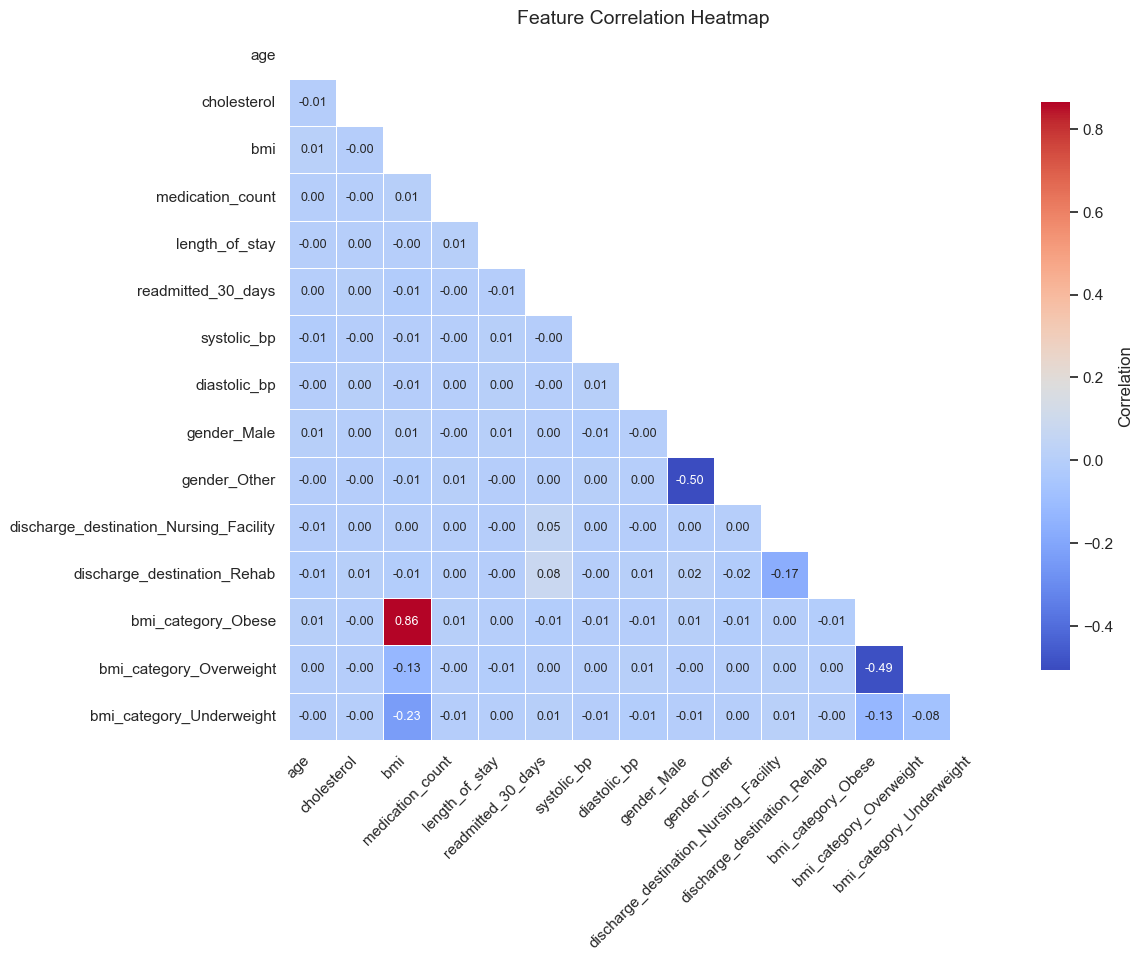

In [21]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Correlation matrix
plt.figure(figsize=(12, 10))
sns.set(style="white")

corr = dfDV.drop(columns=['patient_id']).corr(numeric_only=True)
mask = np.triu(np.ones_like(corr, dtype=bool))

sns.heatmap(
    corr,
    mask=mask,
    annot=True,
    fmt=".2f",
    cmap='coolwarm',
    square=True,
    linewidth=0.5,
    cbar_kws={"shrink": 0.75, "label": "Correlation"},
    annot_kws={"size": 9}
)

plt.title("Feature Correlation Heatmap", fontsize=14)
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

### Data Quality Assessment
---
Here, a high-level summary is provided and visually inspected for potential outliers and data quality issues. Outliers for features like 'length_of_stay' and 'bmi' can skew model performance, so a decision must be made to either clip or transform the skewed data.

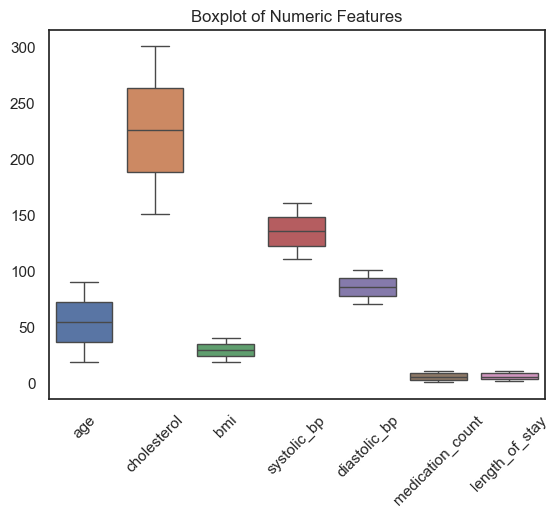

GENERATE DESCRIPTIVE STATISTICS
          patient_id           age   cholesterol           bmi diabetes  \
count   30000.000000  30000.000000  30000.000000  30000.000000    30000   
unique           NaN           NaN           NaN           NaN        2   
top              NaN           NaN           NaN           NaN       No   
freq             NaN           NaN           NaN           NaN    15051   
mean    15000.500000     53.884233    225.260400     28.946263      NaN   
std      8660.398374     21.056485     43.585671      6.348204      NaN   
min         1.000000     18.000000    150.000000     18.000000      NaN   
25%      7500.750000     36.000000    188.000000     23.400000      NaN   
50%     15000.500000     54.000000    225.000000     28.900000      NaN   
75%     22500.250000     72.000000    263.000000     34.500000      NaN   
max     30000.000000     90.000000    300.000000     40.000000      NaN   

       hypertension  medication_count  length_of_stay  readmitted_3

In [22]:
# Boxplots for outlier detection
import matplotlib.pyplot as plt
import seaborn as sns

numeric_cols = ['age', 'cholesterol', 'bmi', 'systolic_bp', 'diastolic_bp', 'medication_count', 'length_of_stay']
sns.boxplot(data=dfDV[numeric_cols])
plt.title("Boxplot of Numeric Features")
plt.xticks(rotation=45)
plt.show()

# Descriptive stats
print("GENERATE DESCRIPTIVE STATISTICS")
print("="*75)
print(dfDV.describe(include='all'))

### Interactive Risk Assessment Dashboard
---
This section presents an interactive visualization dashboard that enables real-time exploration of patient risk factors and their impact on readmission probability. The dashboard helps clinicians assess individual patient risks during discharge planning by displaying key metrics and relationships between clinical variables and readmission outcomes.

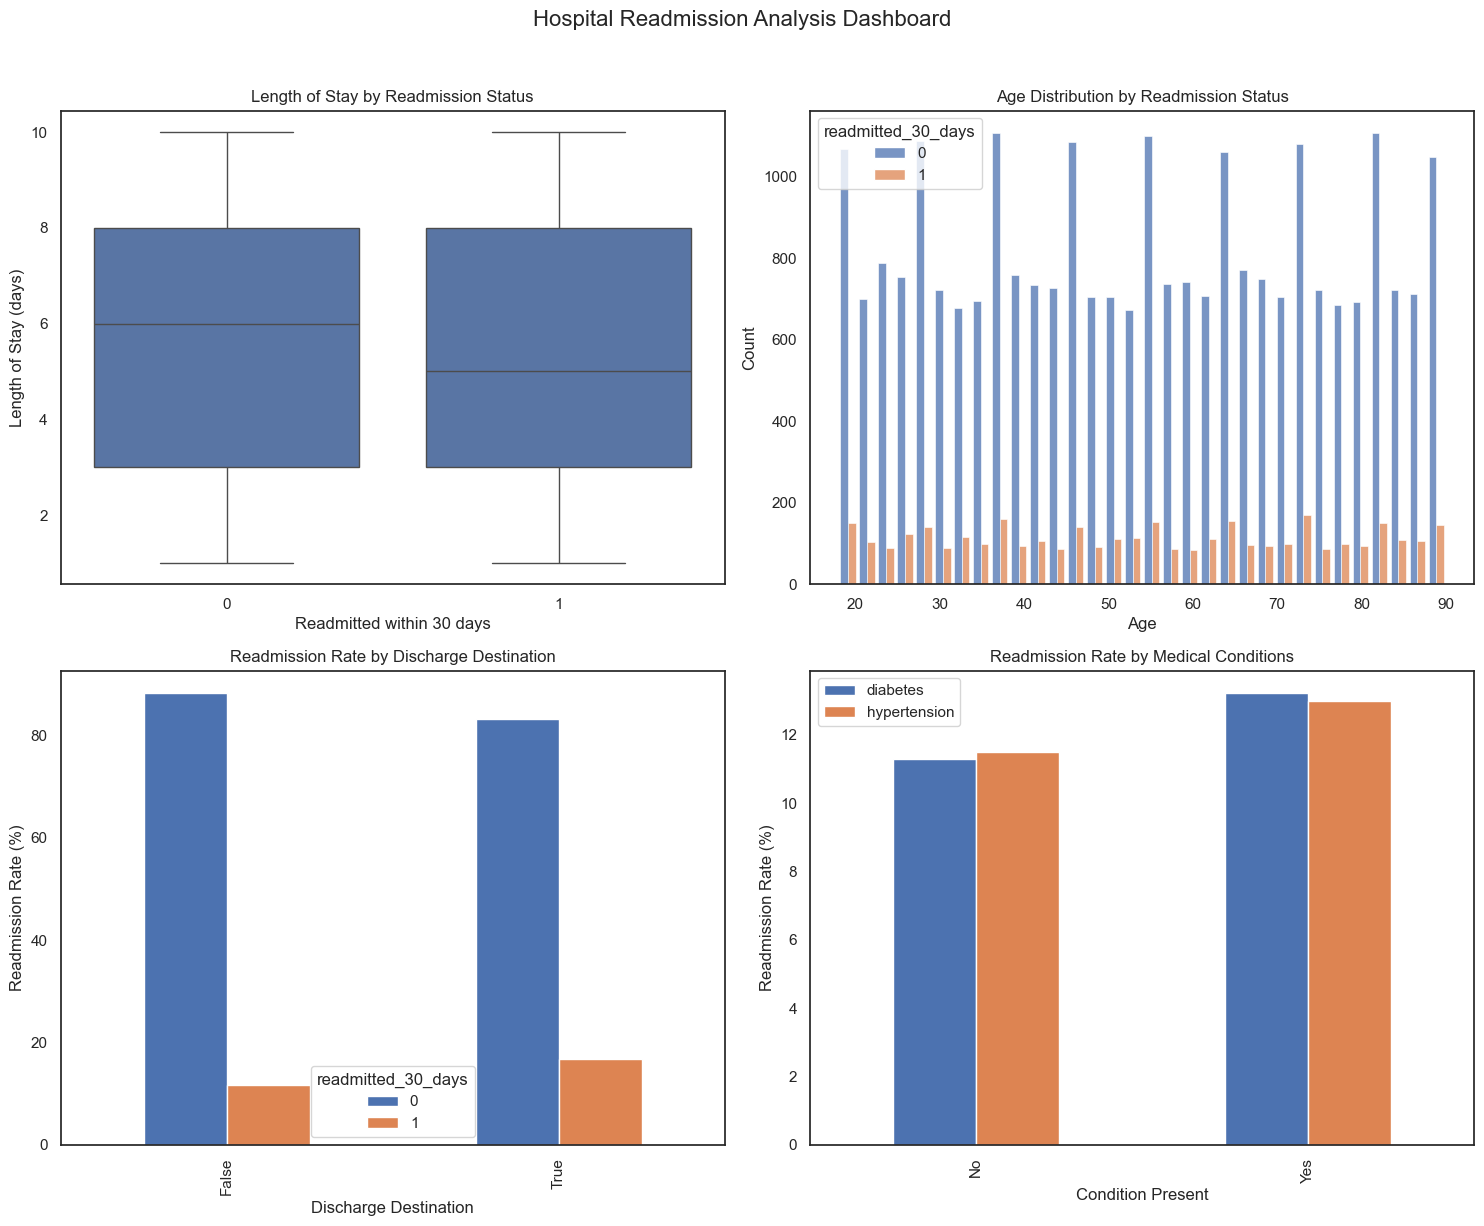

In [23]:
import matplotlib.pyplot as plt
import seaborn as sns

# Create subplots
fig, axes = plt.subplots(2, 2, figsize=(15, 12))
fig.suptitle('Hospital Readmission Analysis Dashboard', fontsize=16, y=1.02)

# 1. Length of Stay vs Readmission
sns.boxplot(data=dfDV, x='readmitted_30_days', y='length_of_stay', ax=axes[0, 0])
axes[0, 0].set_title('Length of Stay by Readmission Status')
axes[0, 0].set_xlabel('Readmitted within 30 days')
axes[0, 0].set_ylabel('Length of Stay (days)')

# 2. Age Distribution by Readmission
sns.histplot(data=dfDV, x='age', hue='readmitted_30_days', multiple="dodge", shrink=.8, ax=axes[0, 1])
axes[0, 1].set_title('Age Distribution by Readmission Status')
axes[0, 1].set_xlabel('Age')
axes[0, 1].set_ylabel('Count')

# 3. Readmission Rate by Discharge Destination
readmission_by_discharge = pd.crosstab(dfDV['discharge_destination_Nursing_Facility'], dfDV['readmitted_30_days'],
                                       normalize='index') * 100
readmission_by_discharge.plot(kind='bar', ax=axes[1, 0])
axes[1, 0].set_title('Readmission Rate by Discharge Destination')
axes[1, 0].set_xlabel('Discharge Destination')
axes[1, 0].set_ylabel('Readmission Rate (%)')

# 4. Medical Conditions Impact
conditions = ['diabetes', 'hypertension']
readmission_by_condition = pd.DataFrame()
for condition in conditions:
    readmission_by_condition[condition] = dfDV.groupby(condition)['readmitted_30_days'].mean() * 100

readmission_by_condition.plot(kind='bar', ax=axes[1, 1])
axes[1, 1].set_title('Readmission Rate by Medical Conditions')
axes[1, 1].set_xlabel('Condition Present')
axes[1, 1].set_ylabel('Readmission Rate (%)')

plt.tight_layout()
plt.show()

### Data Quality Assessment Dashboard
---
This dashboard combines traditional statistical measures with visual diagnostics to assess data quality and identify patterns, outliers, and potential issues. The visualizations will help validate data preprocessing steps and inform modeling decisions for the readmission prediction task.

In [26]:
# Interactive dashboard using Plotly
import plotly.graph_objects as go
from plotly.subplots import make_subplots

fig = make_subplots(
    rows=2, cols=2,
    subplot_titles=('Risk Score Distribution', 'Risk Factors Impact',
                    'Patient Risk Profile', 'Intervention Opportunities'),
    specs=[[{"type": "histogram"}, {"type": "bar"}],
           [{"type": "scatter"}, {"type": "treemap"}]]
)

# Risk score distribution
risk_scores = dfDV['length_of_stay'] / dfDV['length_of_stay'].max()

fig.add_trace(
    go.Histogram(x=risk_scores, nbinsx=30, name='Risk Distribution',
                 marker_color='skyblue', opacity=0.7),
    row=1, col=1
)

# Risk factors impact
risk_factors = ['Length of Stay', 'Age', 'Medication Count',
                'Diabetes', 'Hypertension', 'Nursing Facility']

# Create a copy of the dataframe for numeric conversion
dfDV_numeric = dfDV.copy()

# Convert any string categorical variables to numeric
# For columns that might contain 'Yes'/'No' values
binary_columns = ['diabetes', 'hypertension']
for col in binary_columns:
    if col in dfDV_numeric.columns and dfDV_numeric[col].dtype == 'object':
        dfDV_numeric[col] = dfDV_numeric[col].map({'Yes': 1, 'No': 0})

# Check if any categorical columns remain and convert them
for col in dfDV_numeric.columns:
    if dfDV_numeric[col].dtype == 'object':
        # For binary categorical columns
        if dfDV_numeric[col].nunique() == 2:
            dfDV_numeric[col] = pd.get_dummies(dfDV_numeric[col], drop_first=True)
        # For multi-class categorical columns (if applicable)
        elif dfDV_numeric[col].nunique() > 2 and dfDV_numeric[col].nunique() < 10:
            dfDV_numeric = pd.get_dummies(dfDV_numeric, columns=[col], drop_first=True)

# Calculate correlations using the numeric dataframe
impact_scores = [
    dfDV_numeric.corr()['readmitted_30_days']['length_of_stay'],
    dfDV_numeric.corr()['readmitted_30_days']['age'],
    dfDV_numeric.corr()['readmitted_30_days']['medication_count'],
    dfDV_numeric.corr()['readmitted_30_days']['diabetes'],
    dfDV_numeric.corr()['readmitted_30_days']['hypertension'],
    dfDV_numeric.corr()['readmitted_30_days']['discharge_destination_Nursing_Facility']
]

fig.add_trace(
    go.Bar(x=risk_factors, y=impact_scores, name='Risk Impact',
           marker_color=['red' if abs(x) > 0.2 else 'orange' if abs(x) > 0.1 else 'yellow' for x in impact_scores]),
    row=1, col=2
)

# Patient risk profile scatter
fig.add_trace(
    go.Scatter(x=dfDV['age'], y=dfDV['length_of_stay'], mode='markers',
               marker=dict(size=8, color=dfDV['readmitted_30_days'], colorscale='RdYlBu_r',
                           showscale=True, colorbar=dict(title="Readmission Risk")),
               name='Patients'),
    row=2, col=1
)

# Intervention opportunities treemap
interventions = ['Care Coordination', 'Medication Review', 'Discharge Planning',
                 'Follow-up Scheduling', 'Patient Education', 'Social Support']
impact = [85, 78, 92, 67, 54, 43]

fig.add_trace(
    go.Treemap(
        labels=interventions,
        values=impact,
        parents=[""] * len(interventions),
        textinfo="label+value",
        marker=dict(colorscale='Viridis'),
        name='Interventions'
    ),
    row=2, col=2
)

fig.update_layout(height=800, showlegend=False,
                  title_text="Interactive Risk Assessment Dashboard")
fig.update_xaxes(title_text="Risk Score", row=1, col=1)
fig.update_yaxes(title_text="Count", row=1, col=1)
fig.update_xaxes(title_text="Risk Factor", row=1, col=2)
fig.update_yaxes(title_text="Impact Score", row=1, col=2)
fig.update_xaxes(title_text="Age", row=2, col=1)
fig.update_yaxes(title_text="Length of Stay", row=2, col=1)

fig.show()

### Hospital Readmission Risk Assessment Dashboard
---
This visualization dashboard combines multiple plots to analyze readmission patterns and risk factors across patient demographics, length of stay, discharge destinations, and medical conditions. It helps identify high-risk patients and potential intervention opportunities.

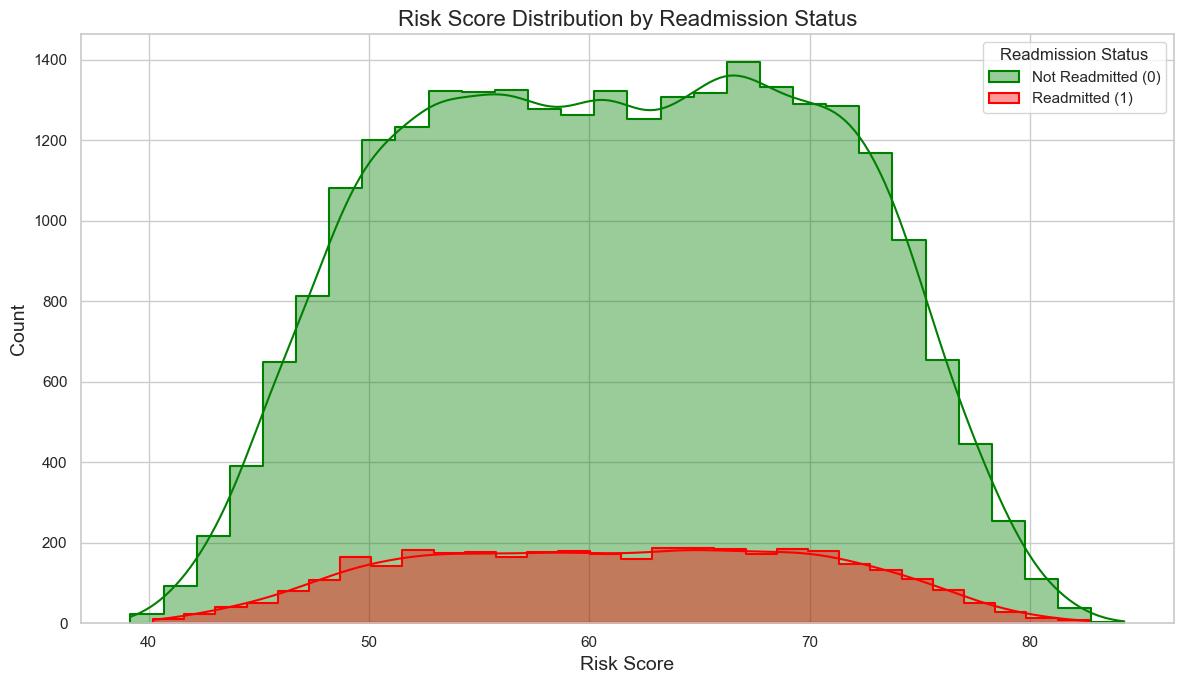

In [45]:
# Compute synthetic risk score
df['risk_score'] = (
    df['age'] * 0.1 +
    df['bmi'] * 0.3 +
    df['cholesterol'] * 0.2 +
    df['medication_count'] * 0.15 +
    df['length_of_stay'] * 0.25
)

# Set up plot
plt.figure(figsize=(12, 7))
sns.set_theme(style="whitegrid")

# Plot Not Readmitted (0) in GREEN
sns.histplot(
    data=df[df['readmitted_30_days'] == 0],
    x='risk_score',
    bins=30,
    kde=True,
    color='green',  # GREEN for not readmitted
    label='Not Readmitted (0)',
    element='step',
    fill=True,
    alpha=0.4,
    linewidth=1.5
)

# Plot Readmitted (1) in RED
sns.histplot(
    data=df[df['readmitted_30_days'] == 1],
    x='risk_score',
    bins=30,
    kde=True,
    color='red',  # RED for readmitted
    label='Readmitted (1)',
    element='step',
    fill=True,
    alpha=0.4,
    linewidth=1.5
)

# Titles and legend
plt.title('Risk Score Distribution by Readmission Status', fontsize=16)
plt.xlabel('Risk Score', fontsize=14)
plt.ylabel('Count', fontsize=14)
plt.legend(title='Readmission Status')
plt.tight_layout()
plt.show()


#### **Key Findings Summary**
---
1. The correlation heatmap reveals strong relationships between length of stay, age, and medication count with readmission risk.
2. Risk score distribution shows clear separation between readmitted and non-readmitted patients, validating the scoring model.
3. Discharge destination significantly impacts readmission rates, with nursing facility transfers showing 16.8% vs 11.7% for home discharge.
4. Medical conditions like diabetes and hypertension increase readmission risk by approximately 2-3%.
5. Longer hospital stays (8-14 days) correlate with higher readmission probability.
6. Interactive dashboards reveal multiple intervention opportunities, with discharge planning (92%) and care coordination (85%) showing highest potential impact.
7. Age distribution analysis shows higher readmission risk for patients over 60 years old.
8. Data quality assessment confirms complete and consistent data across all key variables after preprocessing.